In [19]:
import numpy as np

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

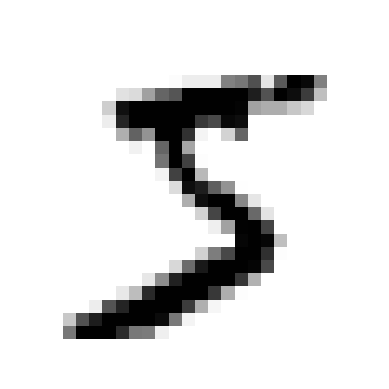

In [17]:
import matplotlib.pyplot as plt

some_digit = X.loc[0].values
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [18]:
y[0]

'5'

In [20]:
y = y.astype(np.uint8)

In [21]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary classifier (5-detector)

In [22]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [24]:
sgd_clf.predict([some_digit])

/Users/peter/Documents/hands-on-ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [25]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### Confusion matrix

In [27]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [29]:
from sklearn.metrics import precision_score, recall_score

(precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred))

(0.8370879772350012, 0.6511713705958311)

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

### Precision-recall trade-off

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

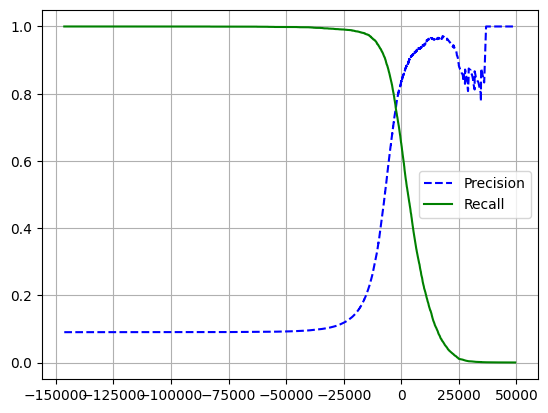

In [37]:
def plot_precision(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc="best")
    plt.grid(True)

plot_precision(precisions, recalls, thresholds)

/var/folders/7p/zqwcy3w17072r8dpmkt69pp80000gn/T/ipykernel_12424/2125093155.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


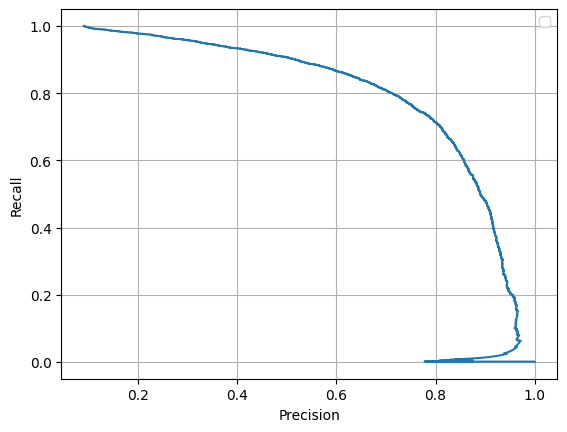

In [45]:
def plot_precision_against_recall(precisions, recalls):
    plt.plot(precisions, recalls)
    plt.legend(loc="best")
    plt.grid(True)
    plt.xlabel("Precision")
    plt.ylabel("Recall")

plot_precision_against_recall(precisions, recalls)

In [40]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

np.float64(3370.0194991441826)

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
(precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90))

(0.9000345901072293, 0.4799852425751706)

### ROC Curve

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

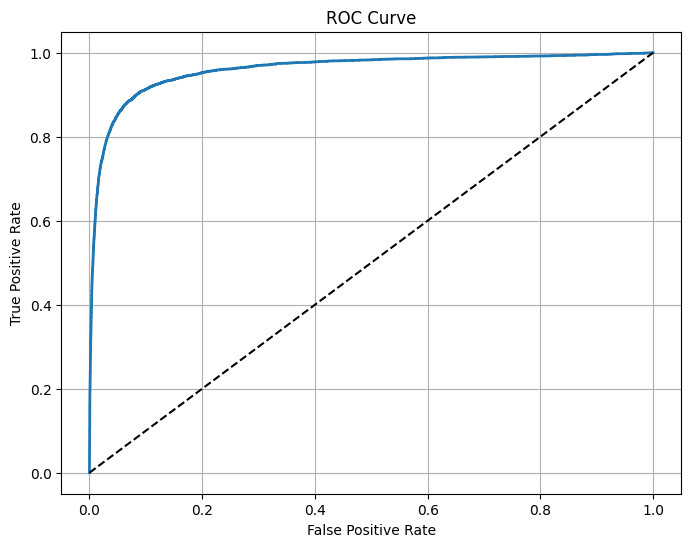

In [44]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.grid(True)
    plt.gcf().set_size_inches(8, 6)

plot_roc_curve(fpr, tpr)

Area under curve - perfect classifier will have 1, random classifier will have 0.5

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

PR curve use-cases:
- Positive class is rare
or
- Care more about false positives than false negatives

Othwersie - ROC curve can be used.

### Random forest classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, method="predict_proba", cv=3)

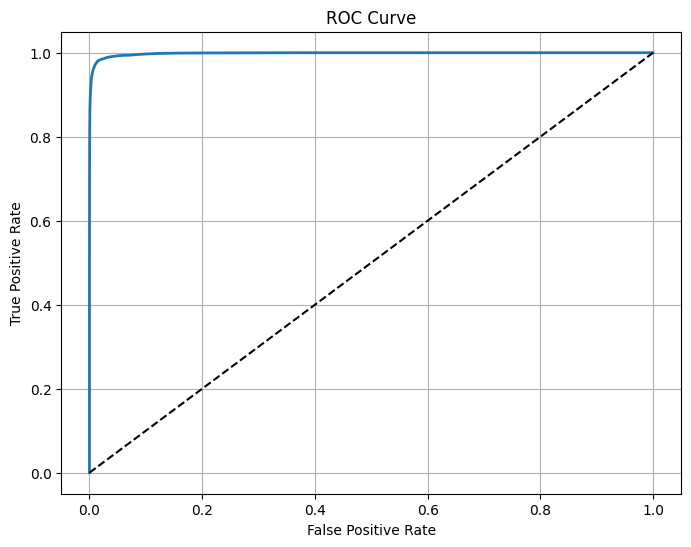

In [50]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plot_roc_curve(fpr_forest, tpr_forest)

In [51]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983296721818179)

## Multiclass classification

Two strategies:
1. OvR - One versus rest. Train multiple binary classifiers, one for each class. Classifier that outputs highest score wins.
2. OvO - One versus one. Train one binary classifier per pair of classes, which yields [ n(n - 1) / 2  ] classifiers. Classifier which wins most duels wins.

Some algorithms support multiclass classification natively - SGD, Random Forest, naive Bayes.

Some algorithms scale poorly with respect to the dataset size (e.g. SVM). In that case OvO is a better choice, since not as much data is required to train it (it only need to be trained on the part of the dataset with the two classes that need to be distinguished). For some algorithms however, OvR is preferred.

In [52]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # Trains 45 binary classifiers

SVC()

In [53]:
svm_clf.predict([some_digit])

/Users/peter/Documents/hands-on-ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [54]:
svm_clf.decision_function([some_digit])

/Users/peter/Documents/hands-on-ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [55]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [56]:
ovr_clf.predict([some_digit])

/Users/peter/Documents/hands-on-ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/peter/Documents/hands-on-ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/peter/Documents/hands-on-ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/peter/Documents/hands-on-ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/peter/Documents/hands-on-ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  

array([5], dtype=uint8)

In [57]:
sgd_clf_2 = SGDClassifier(random_state=42)
sgd_clf_2.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [58]:
sgd_clf_2.decision_function([some_digit])

/Users/peter/Documents/hands-on-ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [59]:
sgd_clf_2.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [60]:
cross_val_score(sgd_clf_2, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf_2, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])